In [3]:
!pip3 install -r requirements.txt

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  |████████████████████████████████| 206 kB 1.1 MB/s 
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

imbalanced-learn 0.8.0 requires scikit-learn>=0.24, but you'll have scikit-learn 0.23.2 which is incompatible.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
# DOWNLOAD WORLD GENDER NAME DICTIONARY DATASET 
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YPRQH8

!curl https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/YPRQH8/SO6SXA -o wgnd_source.tab

  % Total % Received % Xferd  Average Speed   Time Time  Time  Current
         Dload  Upload   Total   Spent Left  Speed
100 19.5M  100 19.5M 0  0  1902k   0  0:00:10  0:00:10 --:--:-- 2533k


In [99]:
# LOAD TRAIN DATA
# NOTE: some names have a first and second name. Majority are only the firstname.

import pandas as pd
names_df = pd.read_csv('wgnd_source.tab', sep='\t')
names_df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,name,code,gender,src_Albertagvt,src_FB,src_INE,src_INSEE,src_MichaelJ,src_Statistics_Denmark,src_UK_National_St,src_US_Census,src_US_SSA,src_WIPO,src_WIPO_manual,src_Wikipedia,src_Yu_et_al,src_statsweden,gchar12,gchar1,gchar2
0,A HANNAN,CA,M,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A JAY,CA,M,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A JAY,GB,M,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A K I L,CA,M,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A LAH,CA,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# CALCULATE A MALENESS SCORE LABEL FOR EACH <NAME, COUNTRY_CODE> 
# NOTE: # every col with prefix 'src_' is the gender from a particular source.
# The column gender is the aggregate (most popular) gender from the various sources.

from sklearn.utils import shuffle

def label_maleness(row):
 male_w, female_w = 0.,0.
 for k,v in row.to_dict().items():
  if k[:4] != "src_":
   continue
  if type(v) != str or v.strip() in ('', '?','=','U'):
   continue
  v = v.strip('?').strip('1')
  if v == 'M': 
   male_w+=1.
  elif v == 'F': 
   female_w+=1.
  elif v == 'B':
   male_w+=.5
   female_w+=.5
  else:
   assert False, f"Unknown gender source value '{v}' for {row}"
 if male_w ==0. and female_w == 0.:
  return None
 return male_w/(male_w+female_w)

unused_columns = ['gchar12', 'gchar1', 'gchar2']
names_df=names_df.drop(unused_columns, axis=1)

names_df['maleness'] = names_df.apply(lambda row: label_maleness(row), axis=1)
cols_to_keep = [c for c in names_df.columns if c[:4] != 'src_']
names_df = names_df[cols_to_keep]

names_df=names_df.rename(columns={"code": "country_code"})
names_df = names_df.dropna()
names_df = shuffle(names_df, random_state=0)

print(f"Number of <name, country_code> datapoints={len(names_df)}")
print()
display("Random sample of data:", names_df.head(10))

Number of <name, country_code> datapoints=276117



'Random sample of data:'

,name,country_code,gender,maleness
9187,ALEICIA,CA,F,0.0
251635,TACHARA,US,F,0.0
273683,VISINIA,CA,F,0.0
177034,MAXEVAN,CA,M,1.0
186826,MOSSAB,CA,M,1.0
177297,MAYADA,CA,F,0.0
154445,LAUN,CA,M,1.0
175885,MASSIMILIANA,IT,F,0.0
141580,KENNYTH,US,M,1.0
229603,SANTI,US,M,1.0


In [101]:
# BALANCE DATASET GENDER FOR EVERY COUNTRY_CODE BY UNDERSAMPLING THE MAJORITY CLASS

from imblearn.under_sampling import RandomUnderSampler

# Looking at India as an example of gender imbalance
indian_names_df = names_df[names_df.country_code=='IN']
print(f"Number of Indian records: female = {len(indian_names_df[names_df.gender=='F'])} and male = {len(indian_names_df[names_df.gender=='M'])}")
   

new_names_df = None
for code in names_df.country_code.unique():
 country_df = names_df[names_df.country_code==code]
 num_males, num_females = len(country_df[country_df.gender=='M']), len(country_df[country_df.gender=='F'])
 maxval, minval = max(num_males, num_females), min(num_males, num_females)
 if minval > 0:
  ros = RandomUnderSampler(random_state=0, sampling_strategy={'M':minval, 'F': minval})
  country_df, _ = ros.fit_resample(country_df, country_df.gender)
  print(f"Country {code} num_males={num_males} num_females={num_females}")
 else:
  print(f"Country {code} has only one class. num_males={num_males} num_females={num_females}")
 if new_names_df is None:
  new_names_df = country_df
 else:
  new_names_df = new_names_df.append(country_df, ignore_index=True)
print(f"Total num records decreased from {len(names_df)} to {len(new_names_df)}")
names_df = new_names_df.drop('gender', axis=1) # we don't need col this anymore


Number of Indian records: female = 636 and male = 2054


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Country CA num_males=32496 num_females=48966
Country US num_males=34326 num_females=58702
Country IT num_males=1440 num_females=1428
Country HU num_males=163 num_females=214
Country GB num_males=14669 num_females=18591
Country BG num_males=754 num_females=1042
Country JP num_males=1032 num_females=554
Country IE num_males=359 num_females=516
Country CH num_males=1029 num_females=1360
Country GR num_males=295 num_females=487
Country EE num_males=533 num_females=597
Country DE num_males=2085 num_females=2025
Country DK num_males=502 num_females=648
Country KR num_males=870 num_females=729
Country IR num_males=1220 num_females=811
Country BY num_males=252 num_females=259
Country KS num_males=456 num_females=545
Country IN num_males=2054 num_females=636
Country RU num_males=229 num_females=264
Country AL num_males=1019 num_females=738
Country FR num_males=663 num_females=1162
Country BA num_males=684 num_females=528
Country ES num_males=779 num_females=920
Country LU num_males=249 num_fema

In [102]:
# NAMES DISTRIBUTION
print(f"Number of unique names={len(names_df.name.unique())}")
print()
display("Top unique names:", names_df.name.value_counts().head(20))

Number of unique names=147528



'Top unique names:'

MARIA  39
DANIEL    38
MARINA    37
NINA   37
DIANA  35
DAVID  35
VERA   34
SARA   34
OLGA   34
RITA   34
EVA    32
SOFIA  31
VALENTINA 31
ROBERT    31
IVAN   30
ANNA   30
MARTIN    30
VIKTOR    30
MARTA  28
BORIS  28
Name: name, dtype: int64

'Percentile buckets of maleness score: '

count 222919.000000
mean    0.499982
std     0.492365
min     0.000000
25%     0.000000
50%     0.500000
75%     1.000000
max     1.000000
Name: maleness, dtype: float64

<AxesSubplot:>

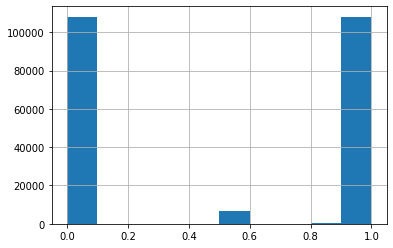

In [103]:
# MALENESS DISTRIBUTION

display("Percentile buckets of maleness score: ", names_df.maleness.describe())
names_df.maleness.hist()

In [104]:
# COUNTRY CODES DISTRIBUTION
country_codes_unique = names_df.country_code.unique()
print(f"Number of unique country_codes={len(country_codes_unique)}")
display(names_df.country_code.value_counts().head(20))

Number of unique country_codes=172


CA 71058
US 69007
GB 29386
DE  4063
IT  2856
NL  2692
CH  2062
IR  1622
TR  1582
ES  1558
BG  1508
SE  1500
RO  1488
AL  1476
KR  1458
AT  1330
FR  1327
IN  1279
IS  1275
BE  1223
Name: country_code, dtype: int64

In [105]:
# TOP NAMES IN ORDER OF DECREASING MALENESS SCORE
for score in (1.,.75,.5,.25,0.):
 display(f"Maleness score = {score}", names_df[names_df.maleness==score].name.value_counts().head(10))
 print()

'Maleness score = 1.0'

DANIEL   35
DAVID    33
VIKTOR   30
IVAN  30
ROBERT   29
MARTIN   29
BORIS    28
EMIL  27
DENIS    27
VALENTIN 26
Name: name, dtype: int64

'Maleness score = 0.75'

CRUZ    1
FRANKIE 1
HOLLIS  1
THANH   1
ARIEL   1
SHAYNE  1
MASON   1
HUNTER  1
TOBY    1
YOUNG   1
Name: name, dtype: int64

'Maleness score = 0.5'

SASA   3
CLAIR  3
HARPER    3
LOU    3
CASEY  3
AMIT   2
BLAYNE    2
DAREL  2
JESSY  2
DOMINIQUE 2
Name: name, dtype: int64

'Maleness score = 0.25'

LEA  1
CARROL  1
RUI  1
AVA  1
KANAME  1
TATSUMI 1
MAYA    1
KEI  1
HIKARU  1
REI  1
Name: name, dtype: int64

'Maleness score = 0.0'

MARIA  38
MARINA 37
NINA   37
DIANA  35
VERA   34
OLGA   34
RITA   34
SARA   33
EVA    32
SOFIA  31
Name: name, dtype: int64

In [106]:
# REMOVE HANDPICKED NAMES HELDOUT FOR TESTING

import re

heldout_names = "Seshadri Sesh Sesha Jabba Daenerys Targaryn Khal Drogo Rhaegal Viserion Frodo Baggins Legolas Gollum Sauron Gandalf Bilbo Baggins Gal Gadot Dobby Yoda Chewbacca Arya Katniss Lisbeth Brienne Bellatrix Cersei"
heldout_name_tokens = set([t.lower() for t in heldout_names.split()])

def is_valid_for_training(name: str):
 return len(set(name.split()).intersection(heldout_name_tokens))==0


names_df.name = names_df.name.str.lower()
names_df = names_df[names_df.name.map(is_valid_for_training)]
display(f"Number of records after filtering holdout names={len(names_df)}")

'Number of records after filtering holdout names=222888'

In [107]:
# NAME TOKENIZATION AND CHARACTER VOCABULARY
# NOTE: Non [a-z] characters are very rare.

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder

max_name_length = max(map(len, names_df.name))
name_tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='OOV')
name_tokenizer.fit_on_texts(names_df.name)
num_name_token_classes = len(name_tokenizer.word_index)+1
display("Name token counts:", str(name_tokenizer.word_counts))

'Name token counts:'

"OrderedDict([('a', 233496), ('s', 68731), ('t', 54442), ('i', 126694), ('n', 126911), ('r', 98752), ('d', 47233), ('y', 46723), ('u', 34917), ('c', 28882), ('e', 153417), ('k', 34680), ('m', 49175), ('g', 19286), ('l', 89047), ('o', 65547), ('b', 21472), ('h', 58482), ('w', 8395), ('p', 10217), ('f', 10661), ('j', 25284), (' ', 12347), ('v', 18453), ('x', 2933), ('z', 13032), ('q', 2975), ('英', 11), ('子', 6), ('아', 3), ('인', 2), ('경', 12), ('영', 21), ('숙', 9), ('소', 1), ('라', 2), ('혜', 4), ('진', 8), ('자', 11), ('瑞', 6), ('潤', 1), ('수', 13), ('연', 3), ('淑', 9), ('보', 2), ('미', 7), ('희', 4), ('枝', 2), ('恩', 11), ('고', 1), ('은', 15), ('嬉', 1), ('예', 3), ('유', 3), ('리', 2), ('昰', 1), ('昀', 1), ('지', 16), ('민', 12), ('智', 5), ('慧', 5), ('주', 3), ('원', 5), ('정', 13), ('惠', 3), ('珍', 5), ('란', 1), ('明', 2), ('다', 1), ('敬', 2), ('선', 1), ('美', 5), ('景', 1), ('화', 1), ('해', 1), ('서', 8), ('현', 11), ('敏', 4), ('序', 1), ('비', 3), ('京', 2), ('采', 1), ('原', 1), ('별', 3), ('銀', 2), ('순', 4), ('옥', 

In [108]:
# COUNTRY_CODE ENCODING

country_code_encoder = OneHotEncoder()
country_code_encoder.fit(names_df.country_code.to_numpy().reshape(-1, 1))

OneHotEncoder()

In [109]:
# INPUT, OUTPUT MATRICES FOR TRAINING

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas

def get_names_matrix(names: pandas.Series):
 # padded, categogical character sequences
 return to_categorical(
  pad_sequences(name_tokenizer.texts_to_sequences(names), 
       maxlen=max_name_length, 
       padding='post', 
       truncating='post'), 
  num_classes= num_name_token_classes)

def get_country_codes_matrix(codes: pandas.Series):
 return country_code_encoder.transform(codes.to_numpy().reshape(-1, 1)).todense()

names_mat = get_names_matrix(names_df.name)
country_codes_mat = get_country_codes_matrix(names_df.country_code)
y_mat = names_df.maleness.to_numpy()

# Sanity check shapes and types
display("names_mat: ", type(names_mat), names_mat.shape)
print()
display("country_codes_mat:", type(country_codes_mat), country_codes_mat.shape)
print()
display("y_mat:", type(y_mat), y_mat.shape)

'names_mat: '

numpy.ndarray

(222888, 30, 327)

'country_codes_mat:'

numpy.matrix

(222888, 172)

'y_mat:'

numpy.ndarray

(222888,)

In [110]:
# DEFINE THE NETWORK AND MODEL

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Concatenate, Dense

inputs = [Input(shape=(max_name_length,num_name_token_classes), name="input_name_char_seq"), 
    Input(shape=(len(country_codes_unique),), name="input_country_code_ohe")]
lstm = LSTM(16, activation='relu', return_sequences=False)
name_embedding = lstm(inputs[0])
x = Concatenate(name="name_and_country_emb")([name_embedding, inputs[1]])
x = Dense(8,activation='relu')(x)
output = Dense(1, activation='sigmoid', name='maleness')(x)

model = Model(inputs=inputs, outputs=[output], name="nameste_gender_clfr")
model.compile(optimizer="Adam", loss="mse", metrics=["mse", "mae"])
model.summary()

Model: "nameste_gender_clfr"
__________________________________________________________________________________________________
Layer (type)     Output Shape   Param #  Connected to      
input_name_char_seq (InputLayer [(None, 30, 327)] 0           
__________________________________________________________________________________________________
lstm_1 (LSTM)       (None, 16)     22016    input_name_char_seq[0][0]  
__________________________________________________________________________________________________
input_country_code_ohe (InputLa [(None, 172)]  0           
__________________________________________________________________________________________________
name_and_country_emb (Concatena (None, 188)    0     lstm_1[0][0]      
                 input_country_code_ohe[0][0]  
__________________________________________________________________________________________________
dense_1 (Dense)     (None, 8)   1512  name_and_country_emb[0][0]    
________________________________

In [111]:
# TRAIN WITH EARLY STOPPING

from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_mse', patience=2, restore_best_weights=True)
history = model.fit([names_mat, country_codes_mat], y_mat, 
     epochs=6, 
     batch_size=32, 
     validation_split=0.2, 
     callbacks=[callback])

Epoch 1/6
5573/5573 [==============================] - 63s 11ms/step - loss: 0.1411 - mse: 0.1411 - mae: 0.2891 - val_loss: 0.1342 - val_mse: 0.1342 - val_mae: 0.2524
Epoch 2/6
5573/5573 [==============================] - 55s 10ms/step - loss: 0.1223 - mse: 0.1223 - mae: 0.2535 - val_loss: 0.1340 - val_mse: 0.1340 - val_mae: 0.2751
Epoch 3/6
5573/5573 [==============================] - 55s 10ms/step - loss: 0.1192 - mse: 0.1192 - mae: 0.2475 - val_loss: 0.1359 - val_mse: 0.1359 - val_mae: 0.2703
Epoch 4/6
5573/5573 [==============================] - 54s 10ms/step - loss: 0.1165 - mse: 0.1165 - mae: 0.2419 - val_loss: 0.1367 - val_mse: 0.1367 - val_mae: 0.2552


In [119]:
# TEST THE MODEL

def predict(name, country_codes):
 name = name.lower()
 return model.predict([get_names_matrix(pd.Series([name]*len(country_codes))), 
        get_country_codes_matrix(pd.Series(country_codes))])

country_codes_to_test = ['KZ', 'RU', 'US','CA','IN','CH', 'KR', 'KE']
for name in ('sesh', 'seshadri', 'dobby', 'daenerys', 'cersei', 'nikita', 'albus'):
 res = predict(name, country_codes_to_test)
 display(f"Name={name}", f"Maleness={list(zip(country_codes_to_test, res))}")
 print()

'Name=sesh'

"Maleness=[('KZ', array([0.6223209], dtype=float32)), ('RU', array([0.6192301], dtype=float32)), ('US', array([0.6860885], dtype=float32)), ('CA', array([0.642344], dtype=float32)), ('IN', array([0.58811444], dtype=float32)), ('CH', array([0.6553823], dtype=float32)), ('KR', array([0.62927777], dtype=float32)), ('KE', array([0.6271552], dtype=float32))]"

'Name=seshadri'

"Maleness=[('KZ', array([0.17439398], dtype=float32)), ('RU', array([0.14547816], dtype=float32)), ('US', array([0.12980515], dtype=float32)), ('CA', array([0.19008008], dtype=float32)), ('IN', array([0.16831037], dtype=float32)), ('CH', array([0.12551397], dtype=float32)), ('KR', array([0.15786704], dtype=float32)), ('KE', array([0.1588803], dtype=float32))]"

'Name=dobby'

"Maleness=[('KZ', array([0.72563064], dtype=float32)), ('RU', array([0.7323735], dtype=float32)), ('US', array([0.81232023], dtype=float32)), ('CA', array([0.74057984], dtype=float32)), ('IN', array([0.70973265], dtype=float32)), ('CH', array([0.79164445], dtype=float32)), ('KR', array([0.74623865], dtype=float32)), ('KE', array([0.7487675], dtype=float32))]"

'Name=daenerys'

"Maleness=[('KZ', array([0.29638362], dtype=float32)), ('RU', array([0.25345027], dtype=float32)), ('US', array([0.22926596], dtype=float32)), ('CA', array([0.31880528], dtype=float32)), ('IN', array([0.28752643], dtype=float32)), ('CH', array([0.2225276], dtype=float32)), ('KR', array([0.272106], dtype=float32)), ('KE', array([0.27361423], dtype=float32))]"

'Name=cersei'

"Maleness=[('KZ', array([0.23513359], dtype=float32)), ('RU', array([0.19856885], dtype=float32)), ('US', array([0.17837015], dtype=float32)), ('CA', array([0.25459826], dtype=float32)), ('IN', array([0.22751498], dtype=float32)), ('CH', array([0.17279229], dtype=float32)), ('KR', array([0.2143448], dtype=float32)), ('KE', array([0.21562767], dtype=float32))]"

'Name=nikita'

"Maleness=[('KZ', array([0.07698518], dtype=float32)), ('RU', array([0.06298822], dtype=float32)), ('US', array([0.05562377], dtype=float32)), ('CA', array([0.08480972], dtype=float32)), ('IN', array([0.07399499], dtype=float32)), ('CH', array([0.05363375], dtype=float32)), ('KR', array([0.06891885], dtype=float32)), ('KE', array([0.06940821], dtype=float32))]"

'Name=albus'

"Maleness=[('KZ', array([0.7827188], dtype=float32)), ('RU', array([0.7881861], dtype=float32)), ('US', array([0.85965693], dtype=float32)), ('CA', array([0.78505886], dtype=float32)), ('IN', array([0.76849324], dtype=float32)), ('CH', array([0.8439081], dtype=float32)), ('KR', array([0.80208653], dtype=float32)), ('KE', array([0.8035681], dtype=float32))]"

In [117]:
# PERSIST MODEL, OTHER ARTIFACTS
import joblib

model.save('nameste_gender_clfr.model')
artifacts = {'name_tokenizer': name_tokenizer, 'country_code_encoder': country_code_encoder, 'max_name_length': max_name_length, 'num_name_token_classes': num_name_token_classes}
joblib.dump(artifacts, 'nameste_gender_clfr.artifacts')

INFO:tensorflow:Assets written to: nameste_gender_clfr.model/assets


['nameste_gender_clfr.artifacts']